Name: Saleh Abdallah

In [79]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score ,classification_report
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

Data Loading

In [80]:
df = pd.read_csv("bank-loan.csv")
df.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


Data Cleaning

In [82]:
# Check null values
df.isnull().sum()

age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     150
dtype: int64

In [83]:
# Percentage of null values
round(df['default'].isnull().sum()/df.shape[0]*100,2)

17.65

In [84]:
df['default'].unique()

array([ 1.,  0., nan])

In [85]:
# Drop null values
df.dropna(subset=['default'], inplace=True)

In [86]:
# Check duplicates
df.duplicated().sum()

0

In [87]:
df.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

EDA

default_label
Did not default    73.9
Defaulted          26.1
Name: proportion, dtype: float64


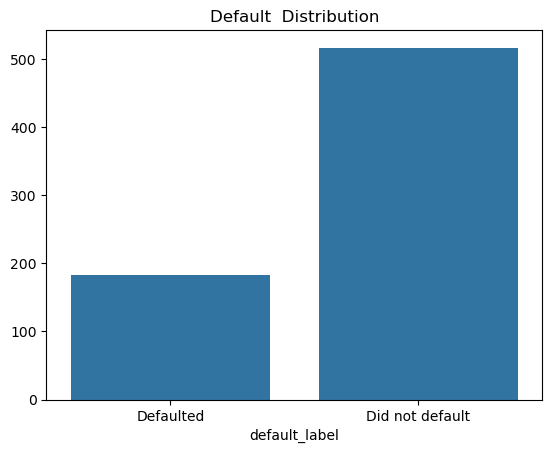

In [88]:
# Target variable distribution
df['default_label'] = df['default'].map({1: 'Defaulted', 0: 'Did not default'})
print(df['default_label'].value_counts(normalize=True).round(3)*100)
sns.countplot(x='default_label', data=df)
plt.title('Default  Distribution')
plt.ylabel('')
plt.show()

In [89]:
features = ['age', 'ed', 'employ', 'income', 'debtinc', 'creddebt', 'othdebt']

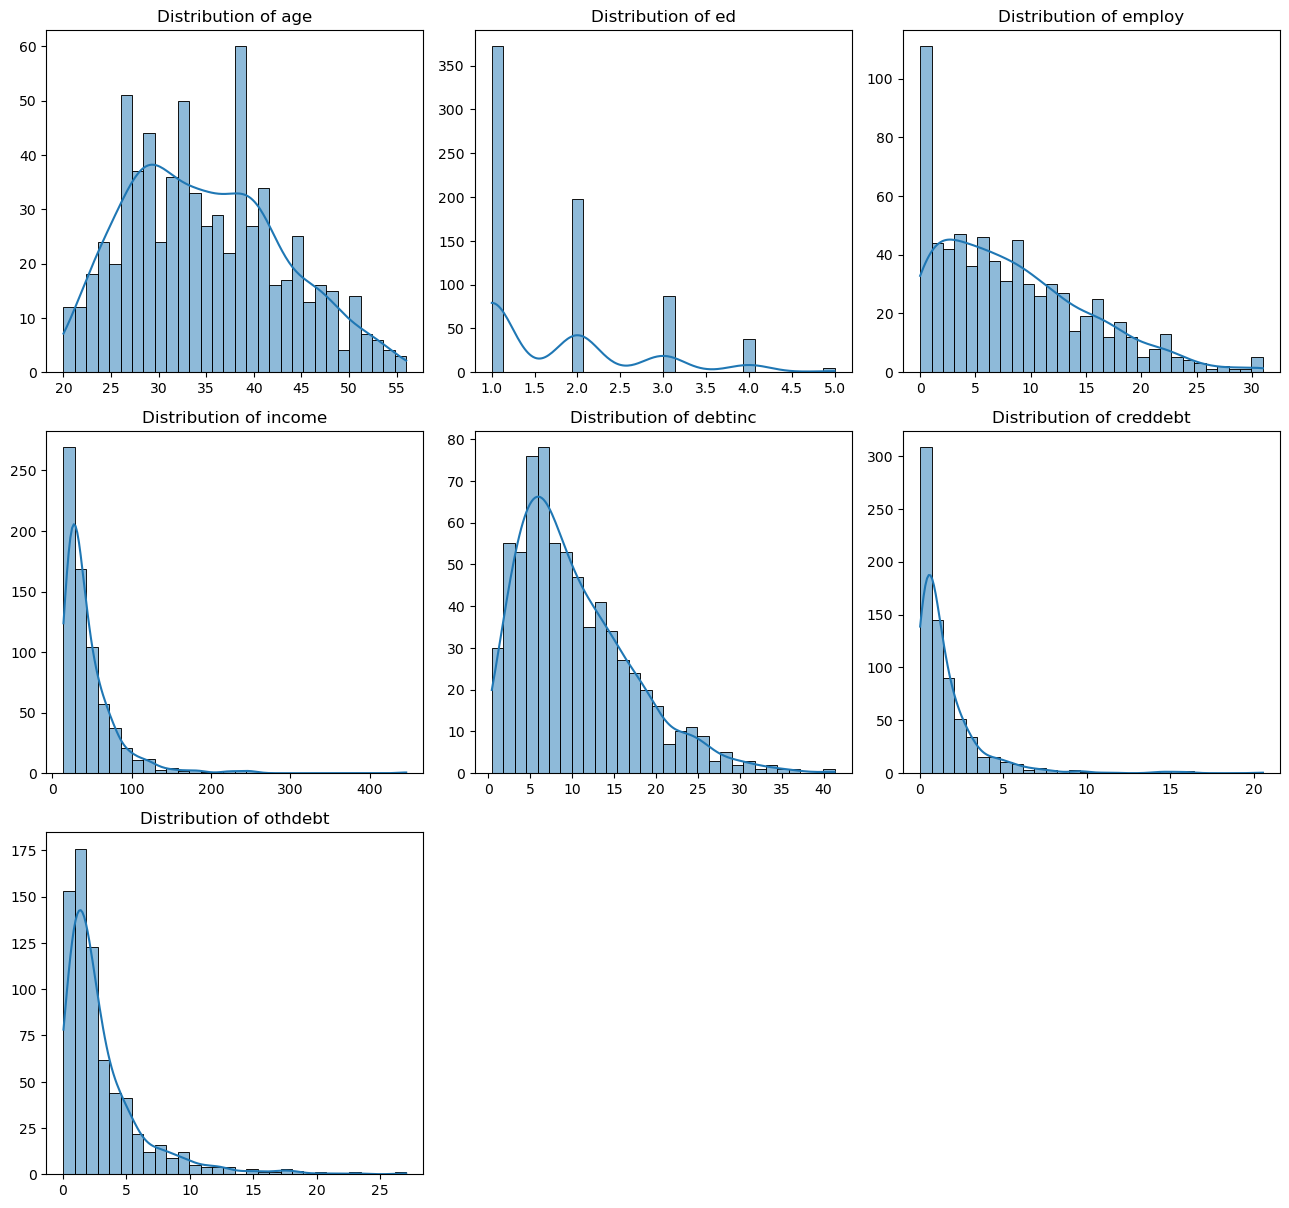

In [90]:
# Histogram
plt.figure(figsize=(13, 32))
for i, x in enumerate(features):
    plt.subplot(8, 3, i+1)
    sns.histplot(df[x], kde=True, bins=30)
    plt.title(f'Distribution of {x}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

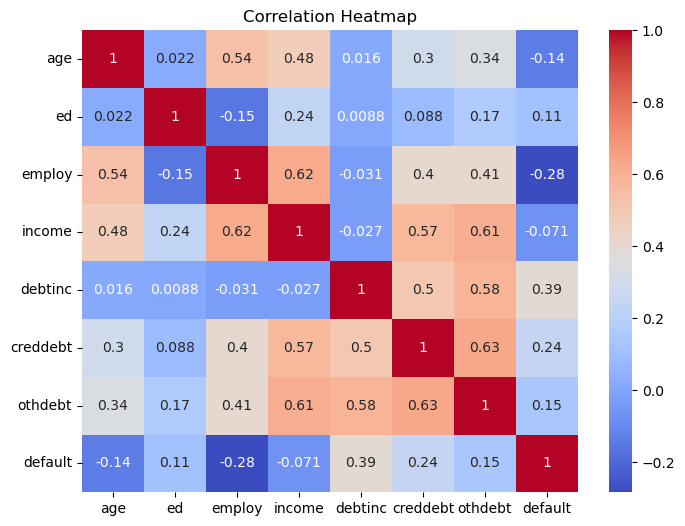

In [91]:
# Correlation matrix
plt.figure(figsize=(8, 6))
corr = df[features + ['default']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Data Preprocessing

In [92]:
df.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default', 'default_label'],
      dtype='object')

In [93]:
# Define the features and target variable
X = df.drop(['address', 'default_label', 'default'], axis=1)
y = df['default']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
scaler = RobustScaler()
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

Model Training

In [95]:
# Train Decision Tree Classifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

Model Predictions

In [96]:
# Predict on test data
y_pred = model.predict(X_test)

Model Evaluation

In [97]:
# Display classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83       102
         1.0       0.54      0.58      0.56        38

    accuracy                           0.75       140
   macro avg       0.69      0.70      0.69       140
weighted avg       0.76      0.75      0.75       140



Fairness Analysis

          accuracy  selection_rate  false_positive_rate  true_positive_rate
AgeGroup                                                                   
20-30     0.767442        0.395349             0.214286            0.733333
30-40     0.739130        0.246377             0.173077            0.470588
40-50     0.739130        0.260870             0.210526            0.500000
50-60     0.750000        0.000000             0.000000            0.000000


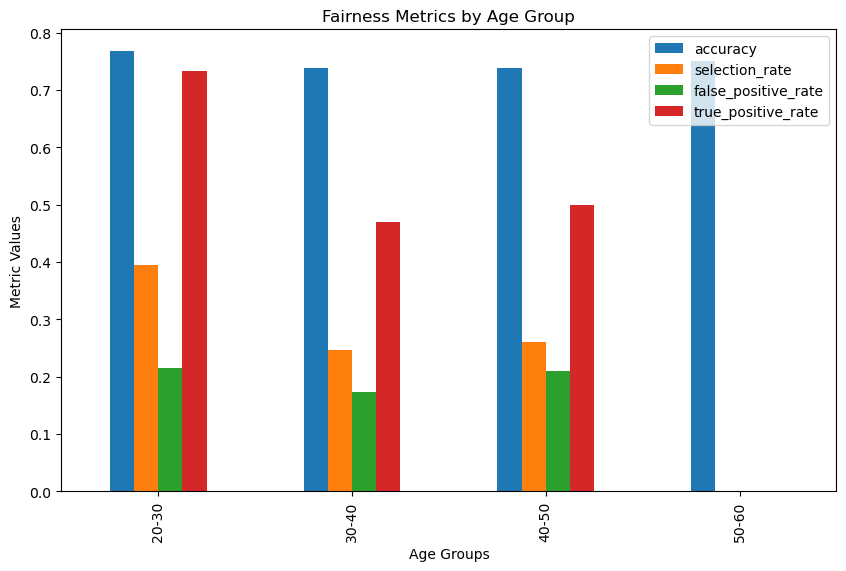

In [98]:
# Fairness Analysis
df['age'] = pd.to_numeric(df['age'], errors='coerce')

df['AgeGroup'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 100], labels=['20-30', '30-40', '40-50', '50-60', '60+'])

sensitive_feature = df.loc[X_test.index, 'AgeGroup'].reset_index(drop=True)

y_true = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred)

valid_rows = sensitive_feature.notna()

metric_frame = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'false_positive_rate': false_positive_rate,
        'true_positive_rate': true_positive_rate
    },
    y_true=y_true[valid_rows],
    y_pred=y_pred[valid_rows],
    sensitive_features=sensitive_feature[valid_rows]
)

# Print the fairness metrics
print(metric_frame.by_group)
metric_frame.by_group.plot(kind='bar', figsize=(10, 6))
plt.title("Fairness Metrics by Age Group")
plt.ylabel("Metric Values")
plt.xlabel("Age Groups")
plt.show()

SHAP Analysis

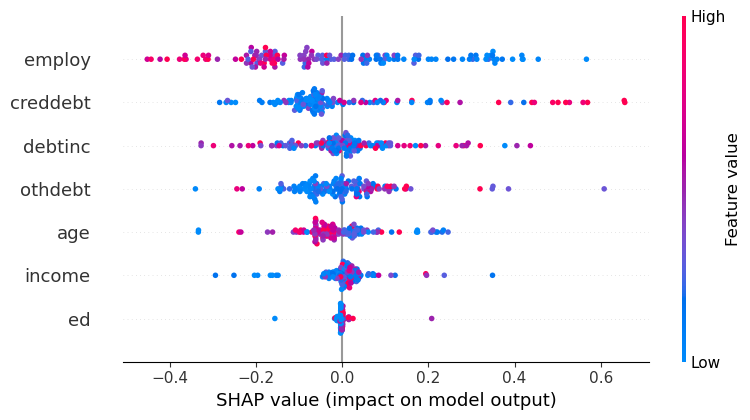

In [99]:
# Explainability Analysis
# SHAP Analysis
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

LIME Analysis

In [100]:
# LIME Analysis
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=['Non-Diabetic', 'Diabetic'],
    mode='classification'
)
exp = explainer.explain_instance(X_test.iloc[0], model.predict_proba)
exp.show_in_notebook(show_table=True)